# H2O vs. Scikit-learn

The purpose of this quick analysis is to observe the differences in random forest implementation between H2O and Scikit-learn. This was prompted after reading an article by Nick Dingwall and Chris Potts entitled, "Are categorical variables getting lost in your random forests?" [1]. Accurately, they point out that Scikit-learn suffers from its inability to handle categorical variables in decision trees (and thus random forests), while H2O has a variety of encoding schemes for categorical features [2]. Analysis is performed using Lending Club Loan Data, which contains compelte loan data between 2007-2015 [3]. This is a mixed dataset containing 890 thousand observations and 75 variables.

[1] https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/

[2] https://github.com/h2oai/h2o-3/blob/f306ebe3096e49fab1ec3e0c2ba62cf370c1cf5c/h2o-docs/src/product/data-science/algo-params/categorical_encoding.rst

[3] https://www.kaggle.com/wendykan/lending-club-loan-data

## Part I

1. I've reduced the feature set to reflect predictors which could be used ahead of loan issuance, such that a binary classifier could predict if the loan will default (class 0) or remain in good standing (class 1). Obviously this is a quick example and not meant to be exhuastive. 

2. Read-in Lending Club data, clean, derive a couple new features, and plot.

3. Given Scikit-learn is unable to utilize categorical variables, perform one-hot encoding, such that there are two datasets, one that will be used by H2O and another which will be used by Scikit-learn.

4. Train two sklearn.ensemble.RandomForestClassifier objects (n_estimators = 1, 10) on one-hot encoded data.

5. Train two h2o.estimators.random_forest.H2ORandomForestEstimator objects (ntrees= 1, 10) using original data.

6. Display ROC-curves and variables importance.

Note: the analysis from [1] above is based upon an artifically created dataset. Within the artifical set, the authors define a categorical variable, *c*, which which takes values from *C*<sup>+</sup> or *C*<sup>-</sup>. Specifically, one will notice that class_1 occurs when *c* starts with the letter A. This is explored in Part II.

In [1]:
import pandas as pd
from pandas import isnull
from sklearn.preprocessing import Imputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score
import numpy as np
import seaborn as sns
from random import randint
%matplotlib inline

In [2]:
# Read in data
data = pd.read_csv('loan.csv',parse_dates=['issue_d','earliest_cr_line'])

# Discard new loans or those that are in grace period
data = data[~data.loan_status.isin(['Issued','In Grace Period'])]

# Remove earliest_cr_line NaN's
data = data[data.earliest_cr_line!='nan']

# Drop months since last delinquent given it is fairly sparse
data.drop('mths_since_last_delinq',axis=1,inplace=True)

# Derive class label
data['label'] = data['loan_status'].apply(lambda x: 1 if x in ['Fully Paid','Current','Does not meet the credit policy. Status:Fully Paid'] else 0)

# Derive desc feature to be if there is an included description 1/0
data['desc'] = data['desc'].apply(lambda x: 0 if isnull(x) else 1)

# Convert term -> int
data['term'] = data['term'].apply(lambda x: int(x.strip()[:2]))

# emp_length -> int
emp_length = data.emp_length.unique().tolist()
map_emp_length = [11,1,2,4,9,10,5,6,7,3,8,0]
data['emp_length'] = data['emp_length'].replace(emp_length,map_emp_length)

# Derive issue_m and issue_y
data['issue_m'] = data['issue_d'].apply(lambda x: x[:3])
data['issue_y'] = data['issue_d'].apply(lambda x: x[4:])
data['issue_y'] = data['issue_y'].astype('int')
data['issue_y'] = data['issue_y'].apply(lambda x: 2000+x)
data.drop('issue_d',axis=1,inplace=True)

# Derive earliest_cr_line_y
data['earliest_cr_line_y'] = data['earliest_cr_line'].apply(lambda x: x[4:])
data['earliest_cr_line_y'] = data['earliest_cr_line_y'].astype('int')
data['earliest_cr_line_y'] = data['earliest_cr_line_y'].apply(lambda x: 2000+x if x in range(16) else 1900+x)
data['length_credit'] = data['issue_y'] - data['earliest_cr_line_y']
data.drop('earliest_cr_line',axis=1,inplace=True)

# Save loan_status if needed later, discard from data
loan_status = data['loan_status']
data.drop('loan_status',axis=1,inplace=True)

# Synthesized predictive high-cardinality categorical feature used in Part II
r=(list(range(100)))
A=[]
B=[]
for i in r:
    A.append('A'+str(i))
    B.append('B'+str(i))
data_2 = data.copy()
data_2['c'] = data_2['label'].apply(lambda x: A[randint(0,99)] if x==1 else B[randint(0,99)])
data_2['c'] = data_2['c'].astype('O')

/Users/darrenshaw/anaconda3/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


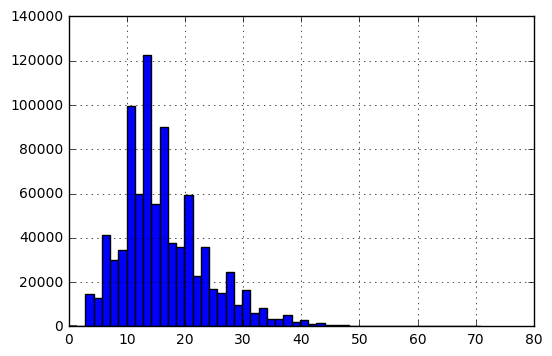

In [3]:
# View distribution of derived variable
data.length_credit.hist(bins=50)

In [4]:
print("number of unique values per dimension")
for i in data.columns.tolist():
    print("{0}: {1}".format(i,len(data[i].unique())))

number of unique values per dimension
loan_amnt: 1372
funded_amnt: 1372
term: 2
int_rate: 541
installment: 68129
grade: 7
sub_grade: 35
emp_length: 12
home_ownership: 6
annual_inc: 48875
desc: 2
purpose: 14
addr_state: 51
dti: 4074
delinq_2yrs: 29
inq_last_6mths: 28
open_acc: 77
pub_rec: 31
revol_bal: 73333
revol_util: 1355
total_acc: 135
label: 2
issue_m: 12
issue_y: 9
earliest_cr_line_y: 67
length_credit: 70


In [5]:
'''
via @sveitser
https://stackoverflow.com/questions/25239958/impute-categorical-missing-values-in-scikit-learn
'''
from sklearn.base import TransformerMixin

class DataFrameImputer(TransformerMixin):

    def __init__(self):
        """Impute missing values.

        Columns of dtype object are imputed with the most frequent value 
        in column.

        Columns of other types are imputed with mean of column.

        """
    def fit(self, X, y=None):

        self.fill = pd.Series([X[c].value_counts().index[0]
            if X[c].dtype == np.dtype('O') else X[c].mean() for c in X],
            index=X.columns)

        return self

    def transform(self, X, y=None):
        return X.fillna(self.fill)
    
data = DataFrameImputer().fit_transform(data)
data_2 = DataFrameImputer().fit_transform(data_2)

In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 872637 entries, 0 to 887378
Data columns (total 26 columns):
loan_amnt             872637 non-null int64
funded_amnt           872637 non-null int64
term                  872637 non-null int64
int_rate              872637 non-null float64
installment           872637 non-null float64
grade                 872637 non-null object
sub_grade             872637 non-null object
emp_length            872637 non-null int64
home_ownership        872637 non-null object
annual_inc            872637 non-null float64
desc                  872637 non-null int64
purpose               872637 non-null object
addr_state            872637 non-null object
dti                   872637 non-null float64
delinq_2yrs           872637 non-null float64
inq_last_6mths        872637 non-null float64
open_acc              872637 non-null float64
pub_rec               872637 non-null float64
revol_bal             872637 non-null int64
revol_util            872637 non

In [7]:
# View pairplot
'''
import seaborn as sns
sns.set_pallete="husl"
sns.set(style="ticks")
sns.pairplot(data,hue='label')
'''

'\nimport seaborn as sns\nsns.set_pallete="husl"\nsns.set(style="ticks")\nsns.pairplot(data,hue=\'label\')\n'

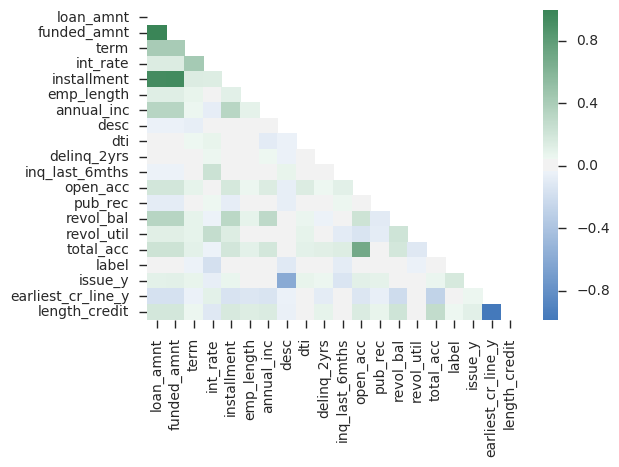

In [8]:
# View correlation matrix
sns.set(style="ticks")
corr = data.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(250, 140, n=9, as_cmap=True)
sns.heatmap(corr,cmap=cmap,mask=mask)

In [9]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(data.drop('label',axis=1),data['label'],test_size=0.2)

# One hot encode data (required by sklearn's Random Forest)
X_train_ohe = pd.get_dummies(X_train,drop_first=True)
X_test_ohe = pd.get_dummies(X_test)
X_test_ohe = X_test_ohe.reindex(columns=X_train_ohe.columns.tolist(),fill_value=0)

# Save original features for later
features = pd.DataFrame(X_train.columns.tolist(),columns=['feature'])
features.reset_index(inplace=True)
features['index'] = features['index']+1

In [10]:
from sklearn.ensemble import RandomForestClassifier
# -----------------------------------
# One tree RF, decision tree adaption
# -----------------------------------
rfc0 = RandomForestClassifier(n_estimators=1,max_features=None,bootstrap=False,max_depth=X_train.shape[1])
rfc0.fit(X_train_ohe,y_train)

scores0 = [l[1] for l in rfc0.predict_proba(X_test_ohe)]
fpr_sklearn0, tpr_sklearn0, thresholds_sklearn0 = roc_curve(y_test, scores0)
auc_sklearn0 = roc_auc_score(y_test, scores0)

# -----------
# Ten tree RF
# -----------
rfc1 = RandomForestClassifier(n_estimators=10,max_depth=X_train.shape[1])
rfc1.fit(X_train_ohe,y_train)

scores1 = [l[1] for l in rfc1.predict_proba(X_test_ohe)]
fpr_sklearn1, tpr_sklearn1, thresholds_sklearn1 = roc_curve(y_test, scores1)
auc_sklearn1 = roc_auc_score(y_test, scores1)

In [11]:
%%capture
import h2o
from h2o.estimators.random_forest import H2ORandomForestEstimator

h2o.init()

X_train['label'] = y_train
X_test['label'] = y_test
X_train = h2o.H2OFrame(X_train.values.tolist())
X_test = h2o.H2OFrame(X_test.values.tolist())

feats = X_train.col_names[:-1] 
label = X_train.col_names[-1] 

# -----------------------------------
# One tree RF, decision tree adaption
# -----------------------------------
drf0 = H2ORandomForestEstimator(ntrees=1,col_sample_rate_per_tree=1.0,sample_rate=1.0,max_depth=X_train.shape[1])
drf0.train(feats, label, training_frame=X_train)

scores_h2o0 = drf0.predict(X_test[:-1])
scores_h2o0 = h2o.as_list(scores_h2o0)

fpr_h2o0, tpr_h2o0, thresholds_h2o0 = roc_curve(y_test,scores_h2o0)
auc_h2o0 = roc_auc_score(y_test, scores_h2o0)

# -----------
# Ten tree RF
# -----------
drf1 = H2ORandomForestEstimator(ntrees=10,max_depth=X_train.shape[1])
drf1.train(feats, label, training_frame=X_train)

scores_h2o1 = drf1.predict(X_test[:-1])

scores_h2o1 = h2o.as_list(scores_h2o1)

fpr_h2o1, tpr_h2o1, thresholds_h2o1 = roc_curve(y_test,scores_h2o1)
auc_h2o1 = roc_auc_score(y_test, scores_h2o1);

#### Results

Observe ROCs and feature importances

In [12]:
# ---------
# View ROCs
# ---------
from bokeh.plotting import figure, show, output_notebook

output_notebook()
p = figure(plot_width=600, plot_height=600)

p.line(fpr_h2o0,tpr_h2o0,line_width=2,legend='h2o, 1 tree: {0:.2f}'.format(auc_h2o0),color='red')
p.line(fpr_sklearn0,tpr_sklearn0,legend='sklearn, 1 tree: {0:.2f}'.format(auc_sklearn0),color='green',line_width=2)

p.line(fpr_h2o1,tpr_h2o1,line_width=2,legend='h2o 10 trees: {0:.2f}'.format(auc_h2o1),color='red',line_dash='dashed')
p.line(fpr_sklearn1,tpr_sklearn1,legend='sklearn, 10 trees: {0:.2f}'.format(auc_sklearn1),color='green',line_width=2,line_dash='dashed')

p.legend.location = "bottom_right"
show(p)

Loading BokehJS ...

In [13]:
# -------------------------------------------------------------
# View sklearn feature importance on RF decision tree adapation
# -------------------------------------------------------------
from bokeh.charts import Bar

foo = pd.DataFrame(rfc0.feature_importances_,columns=['importance'])
foo = foo.sort_values('importance',ascending=False)
foo.reset_index(inplace=True)

var = pd.DataFrame(X_train_ohe.columns.tolist(),columns=['variable'])
var.reset_index(inplace=True)

foo = foo.merge(var,how='inner',on='index')

bar = Bar(foo.loc[:5,['importance','variable']], values='importance', label='variable',stack='variable',legend='bottom_right')
show(bar)

In [14]:
# -------------------------------------------------------------
# View h2o feature importance on RF decision tree adapation
# -------------------------------------------------------------

variables = drf0._model_json['output']['variable_importances']['variable']
variables = [int(x.strip('C')) for x in variables]
foo = pd.DataFrame(variables,columns=['variable'])

scaled_importance = drf0._model_json['output']['variable_importances']['scaled_importance']
foo['importance'] = scaled_importance

foo = foo.merge(features,how='inner',left_on='variable',right_on='index')
foo.loc[:5,['importance','feature','variable']]

bar = Bar(foo.loc[:5,['importance','feature']], values='importance',label='feature',stack='feature',legend='bottom_right')
show(bar)

## Part II

As noted above, the authors in [1] utilize a strongly predictive, yet high cardinality variable. Thus, Part I is repeated, but with the introduction of variable *c*. Here, the limiation of sklearn on categorical values can be seen.

In [15]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(data_2.drop('label',axis=1),data_2['label'],test_size=0.2)

# One hot encode data (required by sklearn's Random Forest)
X_train_ohe = pd.get_dummies(X_train,drop_first=True)
X_test_ohe = pd.get_dummies(X_test)
X_test_ohe = X_test_ohe.reindex(columns=X_train_ohe.columns.tolist(),fill_value=0)

# Save original features for later
features = pd.DataFrame(X_train.columns.tolist(),columns=['feature'])
features.reset_index(inplace=True)
features['index'] = features['index']+1

del data

In [16]:
# -----------------------------------
# One tree RF, decision tree adaption
# -----------------------------------
rfc0 = RandomForestClassifier(n_estimators=1,max_features=None,bootstrap=False,max_depth=X_train.shape[1])
rfc0.fit(X_train_ohe,y_train)

scores0 = [l[1] for l in rfc0.predict_proba(X_test_ohe)]
fpr_sklearn0, tpr_sklearn0, thresholds_sklearn0 = roc_curve(y_test, scores0)
auc_sklearn0 = roc_auc_score(y_test, scores0)

# -----------
# Ten tree RF
# -----------
rfc1 = RandomForestClassifier(n_estimators=10,max_depth=X_train.shape[1])
rfc1.fit(X_train_ohe,y_train)

scores1 = [l[1] for l in rfc1.predict_proba(X_test_ohe)]
fpr_sklearn1, tpr_sklearn1, thresholds_sklearn1 = roc_curve(y_test, scores1)
auc_sklearn1 = roc_auc_score(y_test, scores1)

In [17]:
%%capture
X_train['label'] = y_train
X_test['label'] = y_test
X_train = h2o.H2OFrame(X_train.values.tolist())
X_test = h2o.H2OFrame(X_test.values.tolist())

feats = X_train.col_names[:-1] 
label = X_train.col_names[-1] 

# -----------------------------------
# One tree RF, decision tree adaption
# -----------------------------------
drf0 = H2ORandomForestEstimator(ntrees=1,col_sample_rate_per_tree=1.0,sample_rate=1.0,max_depth=X_train.shape[1])
drf0.train(feats, label, training_frame=X_train)

scores_h2o0 = drf0.predict(X_test[:-1])
scores_h2o0 = h2o.as_list(scores_h2o0)

fpr_h2o0, tpr_h2o0, thresholds_h2o0 = roc_curve(y_test,scores_h2o0)
auc_h2o0 = roc_auc_score(y_test, scores_h2o0)

# -----------
# Ten tree RF
# -----------
drf1 = H2ORandomForestEstimator(ntrees=10,max_depth=X_train.shape[1])
drf1.train(feats, label, training_frame=X_train)

scores_h2o1 = drf1.predict(X_test[:-1])
scores_h2o1 = h2o.as_list(scores_h2o1)

fpr_h2o1, tpr_h2o1, thresholds_h2o1 = roc_curve(y_test,scores_h2o1)
auc_h2o1 = roc_auc_score(y_test, scores_h2o1);

#### Results

In [18]:
# ---------
# View ROCs
# ---------
p = figure(plot_width=600, plot_height=600)

p.line(fpr_h2o0,tpr_h2o0,line_width=2,legend='h2o, 1 tree: {0:.2f}'.format(auc_h2o0),color='red')
p.line(fpr_sklearn0,tpr_sklearn0,legend='sklearn, 1 tree: {0:.2f}'.format(auc_sklearn0),color='green',line_width=2)

p.line(fpr_h2o1,tpr_h2o1,line_width=2,legend='h2o 10 trees: {0:.2f}'.format(auc_h2o1),color='red',line_dash='dashed')
p.line(fpr_sklearn1,tpr_sklearn1,legend='sklearn, 10 trees: {0:.2f}'.format(auc_sklearn1),color='green',line_width=2,line_dash='dashed')

p.legend.location = "bottom_right"
show(p)

In [19]:
# -------------------------------------------------------------
# View sklearn feature importance on RF decision tree adapation
# -------------------------------------------------------------
foo = pd.DataFrame(rfc0.feature_importances_,columns=['importance'])
foo = foo.sort_values('importance',ascending=False)
foo.reset_index(inplace=True)

var = pd.DataFrame(X_train_ohe.columns.tolist(),columns=['variable'])
var.reset_index(inplace=True)

foo = foo.merge(var,how='inner',on='index')

bar = Bar(foo.loc[:5,['importance','variable']], values='importance', label='variable',stack='variable',legend='bottom_right')
show(bar)

In [20]:
# -------------------------------------------------------------
# View h2o feature importance on RF decision tree adapation
# -------------------------------------------------------------
variables = drf0._model_json['output']['variable_importances']['variable']
variables = [int(x.strip('C')) for x in variables]
foo = pd.DataFrame(variables,columns=['variable'])

scaled_importance = drf0._model_json['output']['variable_importances']['scaled_importance']
foo['importance'] = scaled_importance

foo = foo.merge(features,how='inner',left_on='variable',right_on='index')
foo = foo.sort_values('importance',ascending=False)
foo.loc[:5,['importance','feature','variable']]

bar = Bar(foo.loc[:5,['importance','feature']], values='importance',label='feature',stack='feature',legend='bottom_right')
show(bar)

## Part III

Next, utilize GBM, as one would expect the sklearn limitation to extend to stumps (GBM, depth = 1)

In [26]:
# Train/test split
X_train, X_test, y_train, y_test = train_test_split(data_2.drop('label',axis=1),data_2['label'],test_size=0.2)

# One hot encode data (required by sklearn's Random Forest)
X_train_ohe = pd.get_dummies(X_train,drop_first=True)
X_test_ohe = pd.get_dummies(X_test)
X_test_ohe = X_test_ohe.reindex(columns=X_train_ohe.columns.tolist(),fill_value=0)

# Save original features for later
features = pd.DataFrame(X_train.columns.tolist(),columns=['feature'])
features.reset_index(inplace=True)
features['index'] = features['index']+1

In [27]:
%%capture
from h2o.estimators.gbm import H2OGradientBoostingEstimator

X_train['label'] = y_train
X_test['label'] = y_test
X_train = h2o.H2OFrame(X_train.values.tolist())
X_test = h2o.H2OFrame(X_test.values.tolist())

feats = X_train.col_names[:-1] 
label = X_train.col_names[-1] 

# --------------
# 50 tree stumps
# --------------
drf0 = H2OGradientBoostingEstimator(ntrees=50,max_depth=1)
drf0.train(feats, label, training_frame=X_train)

scores_h2o0 = drf0.predict(X_test[:-1])
scores_h2o0 = h2o.as_list(scores_h2o0)

fpr_h2o0, tpr_h2o0, thresholds_h2o0 = roc_curve(y_test,scores_h2o0)
auc_h2o0 = roc_auc_score(y_test, scores_h2o0)

In [23]:
from sklearn.ensemble import GradientBoostingClassifier
# -----------------------------------
# Gradient Boost, 50 stumps
# -----------------------------------
rfc0 = GradientBoostingClassifier(n_estimators=50,max_depth=1)
rfc0.fit(X_train_ohe,y_train)

scores0 = [l[1] for l in rfc0.predict_proba(X_test_ohe)]
fpr_sklearn0, tpr_sklearn0, thresholds_sklearn0 = roc_curve(y_test, scores0)
auc_sklearn0 = roc_auc_score(y_test, scores0)

# ------------------------
# Gradient Boost, default
# ------------------------
rfc1 = GradientBoostingClassifier()
rfc1.fit(X_train_ohe,y_train)

scores1 = [l[1] for l in rfc1.predict_proba(X_test_ohe)]
fpr_sklearn1, tpr_sklearn1, thresholds_sklearn1 = roc_curve(y_test, scores1)
auc_sklearn1 = roc_auc_score(y_test, scores1)

#### Results

In [28]:
# ---------
# View ROCs
# ---------
p = figure(plot_width=600, plot_height=600)

p.line(fpr_h2o0,tpr_h2o0,line_width=2,legend='h2o GBM stumps: {0:.2f}'.format(auc_h2o0),color='red')
p.line(fpr_sklearn0,tpr_sklearn0,legend='sklearn, GBM stumps: {0:.2f}'.format(auc_sklearn0),color='green',line_width=2)
p.line(fpr_sklearn1,tpr_sklearn1,legend='sklearn, GBM default: {0:.2f}'.format(auc_sklearn1),color='green',line_width=2,line_dash='dashed')

p.legend.location = "bottom_right"
show(p)

# Conclusion

#### Part I

Scikit-learn takes the AUC-cake over H2O in Part I. This contains two models, one an "adapted" RF to represent a single decision tree (both libraries) and the other with ten trees. Both libraries set to a common max_depth and other parameters kept as default. This is not necessairly surprising, as it is possible that the original dataset contains categorical variables which are not very predictive compared to numerical attributes. 

It should be noted that Scikit-learn (mean decrease in Gini) and H2O have slightly different ways of determining feature importance. Nevertheless, they are both used for their respective library. From observing feature importance in the single-tree RF, it is of note that H2O picks out a categorical variable, addr_state, as the most important, while Scikit-learn has no categorical variables in its top five. 

#### Part II

The addition of a high cardinality and predictive categorical variable shows where Scikit-learn can struggle. H2O significantly outperforms Scikit-learn at both the one tree and ten tree RF level. Again, viewing feature importance it can be seen that H2O places nearly all importance on *c*, while one-hot-encoded versions of *c* are seen in the lower portions of the top five features identified by Scikit.

#### Part III

Seeing that Scikit may falter on categorical variables, Part II can be extended to view performance using Gradient Boosting. An H2O GBM is trained to produce 50 decision stumps using otherwise default parameters. Similarly, Scikit-learn is used to train 50 decision stumps, while also giving one go at a fully-default parametered GBM.

Expected results are produced, as the decision stump versions see poorer performance in the Scikit-learn version, though the second fully-default version does match the H2O stump performance.

#### Takeaway

This was a good exercise to get used to H2O in python as well as observe the limitation of Scikit-learn reported in [1]. Ultimately, if one believes their categorical data to be highly predictive, it may be easier to reach for H2O instead of second guessing your one-hot encoding with Scikit-learn.

#### Features used from original Lending Club dataset:
loan_amnt,
funded_amnt.
term,
int_rate,
installment,
grade,
sub_grade,
emp_length,
home_ownership,
annual_inc,
issue_d,
loan_status,
desc,
purpose,
addr_state,
dti,
delinq_2yrs,
earliest_cr_line,
inq_last_6mths,
mths_since_last_delinq,
open_acc,
pub_rec,
revol_bal,
revol_util,
total_acc,